In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from amplpy import AMPL
import matplotlib.lines as mlines

In [25]:
# Number of periods you want
m = 4
# q values to try
qs = [3, 5, 10, 20]



returns = pd.read_csv("returns.csv", index_col=0)
tickers = returns.columns

split_point = int(0.7 * len(returns))
out_sample = returns.iloc[split_point:].copy()


n_rows = len(out_sample)
period_length = n_rows // m

# Create period labels
periods = np.repeat(np.arange(1, m + 1), period_length)
remainder = n_rows - len(periods)
if remainder > 0:
    periods = np.append(periods, [m] * remainder)

# Add period column
out_sample['period'] = periods
out_sample_tall = out_sample.reset_index().melt(id_vars=["Date", "period"], var_name="Ticker", value_name="Return")


is_windows = []
period_lengths = out_sample['period'].value_counts().sort_index()

for i in range(1, m + 1):    
    # Get the first date of this OOS window
    start_date = out_sample[out_sample['period'] == i].index[0]

    # Define IS window: go back `split` number of rows ending at start_date (non-inclusive)
    is_window = returns.loc[:start_date].iloc[-split_point:]
    is_windows.append(is_window)
    
#Get full sp100 returns

market_caps = {}

selected_tickers = returns.columns
for ticker in selected_tickers:
    try:
        info = yf.Ticker(ticker).info
        market_caps[ticker] = info.get('marketCap', 0)
    except Exception as e:
        print(f"Error retrieving {ticker}: {e}")
        market_caps[ticker] = 0
        
total_market_value = sum(market_caps.values())

tickers = []
weights_list = []
# Compute weights
for ticker in selected_tickers:
    cap = market_caps[ticker]
    weight = cap / total_market_value
    tickers.append(ticker)
    weights_list.append(weight)

sp_weights = pd.DataFrame({
    'Ticker': tickers,
    'Weight': weights_list
})  

sp100 = pd.merge(out_sample_tall, sp_weights, on=['Ticker'], how='inner')
sp100['Weighted_Return'] = sp100['Return'] * sp100['Weight']
sp100_returns = sp100.groupby('Date')['Weighted_Return'].sum().reset_index()
sp100_returns = sp100_returns.rename(columns={'Weighted_Return': 'Portfolio_Return'})

def getIndexReturns(q):
    results = []
    for i in range(m):
        window_returns = is_windows[i]

        flat_returns = window_returns.copy()
        flat_returns.columns = window_returns.columns
        tickers = window_returns.columns

        # Calculate correlations if not done yet
        correlations = flat_returns.corr()
        #tickers = [col[1] for col in stock_prices.columns]
        #x_matrix = pd.DataFrame(np.zeros((len(tickers), len(tickers))), index=tickers, columns=tickers)

        # Write to AMPL-style .dat file
        file_name = "data.txt"
        with open(file_name, "w") as f:
            f.write("set STOCKS := " + " ".join(tickers) + " ;\n\n")

            f.write("param q := " + str(q) + " ;\n\n")

            f.write("param r:\n    " + " ".join(tickers) + " :=\n")
            for t1 in tickers:
                row = " ".join(f"{correlations.loc[t1, t2]:.4f}" for t2 in tickers)
                f.write(f"{t1} {row}\n")
            f.write(";\n") 
            
            
        # Run and solve for period m
        ampl = AMPL()
        ampl.setOption('solver', 'gurobi')
        ampl.read("max_corr.txt")
        ampl.read_data("data.txt")
        ampl.solve()

        y = ampl.get_variable("y").get_values().to_pandas()
        selected = y[y["y.val"] == 1]
        results.append(selected.index.tolist())
    
    periods = []
    tickers = []
    weights_list = []

    for i in range(m):
        market_caps = {}
        selected_tickers = results[i]
        for ticker in selected_tickers:
            try:
                info = yf.Ticker(ticker).info
                market_caps[ticker] = info.get('marketCap', 0)
            except Exception as e:
                print(f"Error retrieving {ticker}: {e}")
                market_caps[ticker] = 0
                
        total_market_value = sum(market_caps.values())

        # Compute weights
        for ticker in selected_tickers:
            cap = market_caps[ticker]
            weight = cap / total_market_value if total_market_value > 0 else 0
            periods.append(i + 1)
            tickers.append(ticker)
            weights_list.append(weight)

    weights_df = pd.DataFrame({
        'period': periods,
        'Ticker': tickers,
        'Weight': weights_list
    })  
    #Get index return
    portfolio = pd.merge(out_sample_tall, weights_df, on=['period', 'Ticker'], how='inner')
    portfolio['Weighted_Return'] = portfolio['Return'] * portfolio['Weight']
    portfolio_return = portfolio.groupby('Date')['Weighted_Return'].sum().reset_index()
    portfolio_return = portfolio_return.rename(columns={'Weighted_Return': 'Portfolio_Return'})
    return portfolio_return

In [ ]:
# Build merged return DataFrame
combined = sp100_returns[['Portfolio_Return']].rename(columns={'Portfolio_Return': 'SP100'})

for q in qs:
    index = getIndexReturns(q)
    combined[str(q)] = index['Portfolio_Return']

combined['Period'] = periods.tolist()
period_change_locs = combined['Period'].ne(combined['Period'].shift()).to_numpy().nonzero()[0]


Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 68.001
1494 simplex iterations
1 branching node
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 60.2117
1529 simplex iterations
1 branching node
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 57.9724
1862 simplex iterations
1 branching node
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 56.9249
1373 simplex iterations
1 branching node
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 70.6261
911 simplex iterations
1 branching node
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 63.3561
1112 simplex iterations
1 branching node
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 61.5819
1250 simplex iterations
1 branching node
absmipgap=0.00555, relmipgap=9.01239e-05
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 60.1916
1164 simplex iterations
1 branching node
Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 74.4079
708 simplex iterations
1 branching node
Gurobi 1

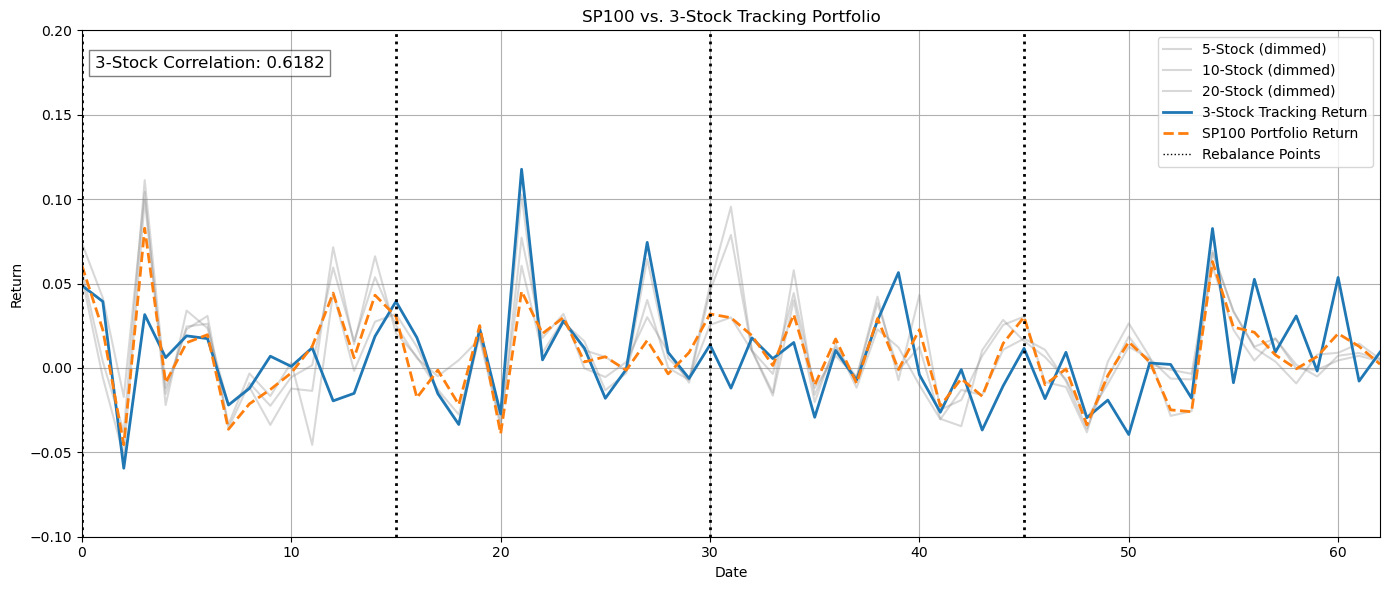

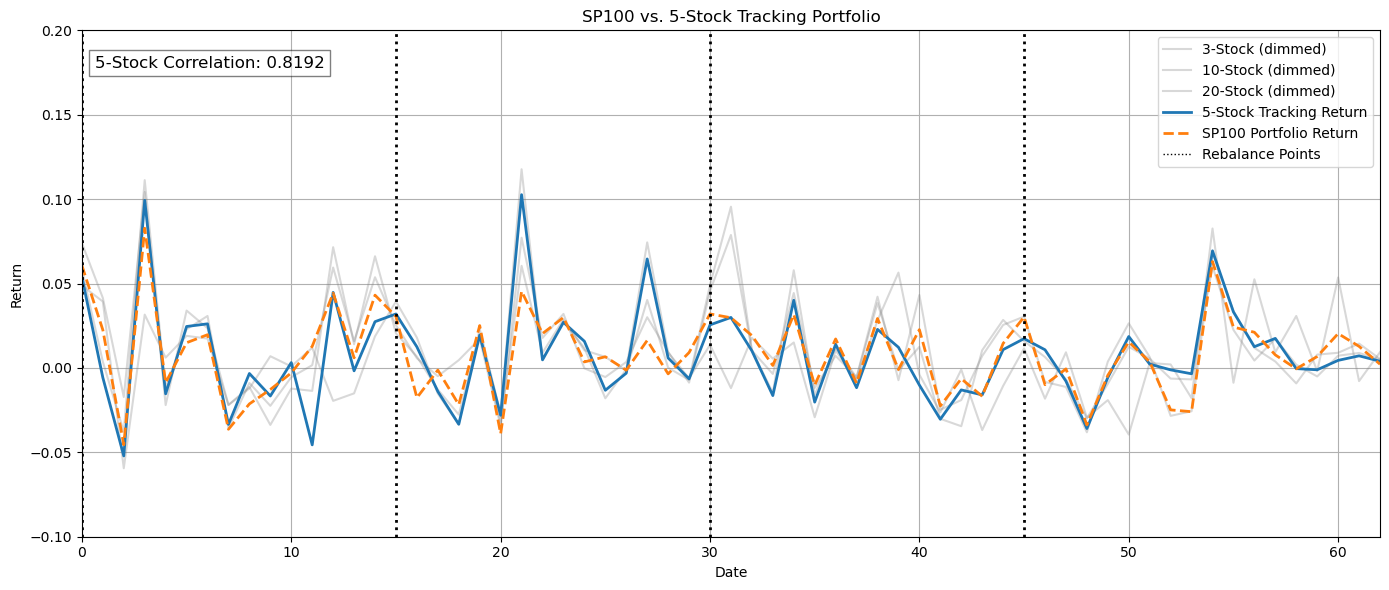

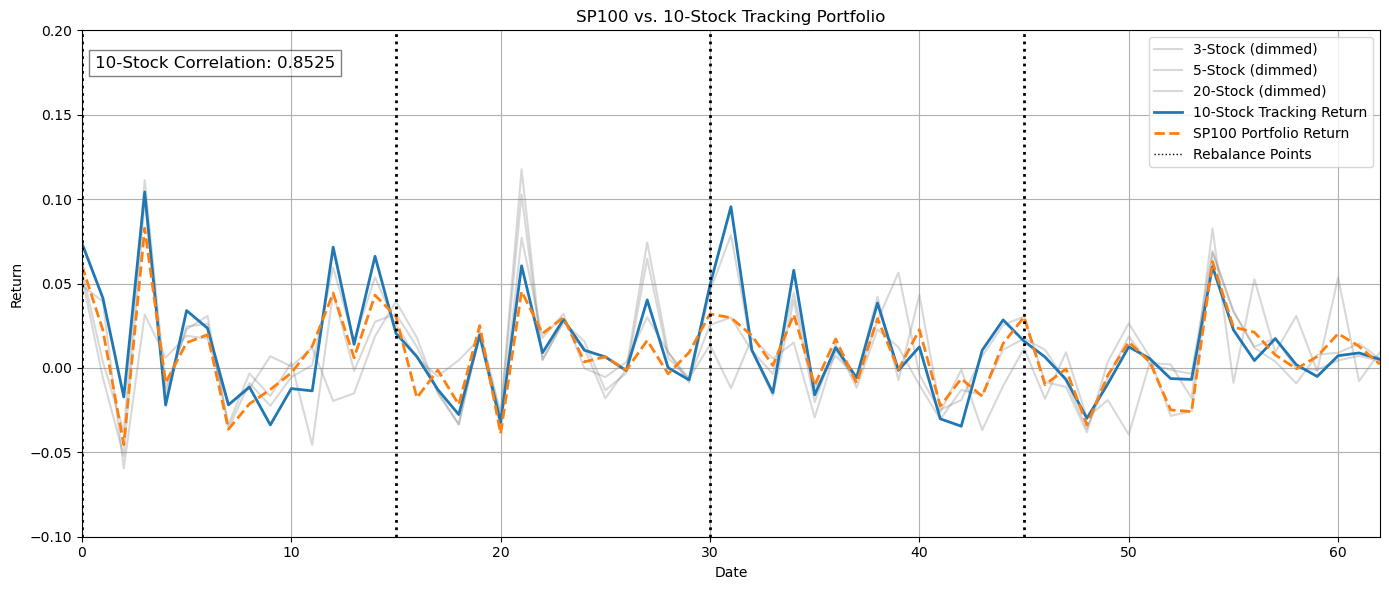

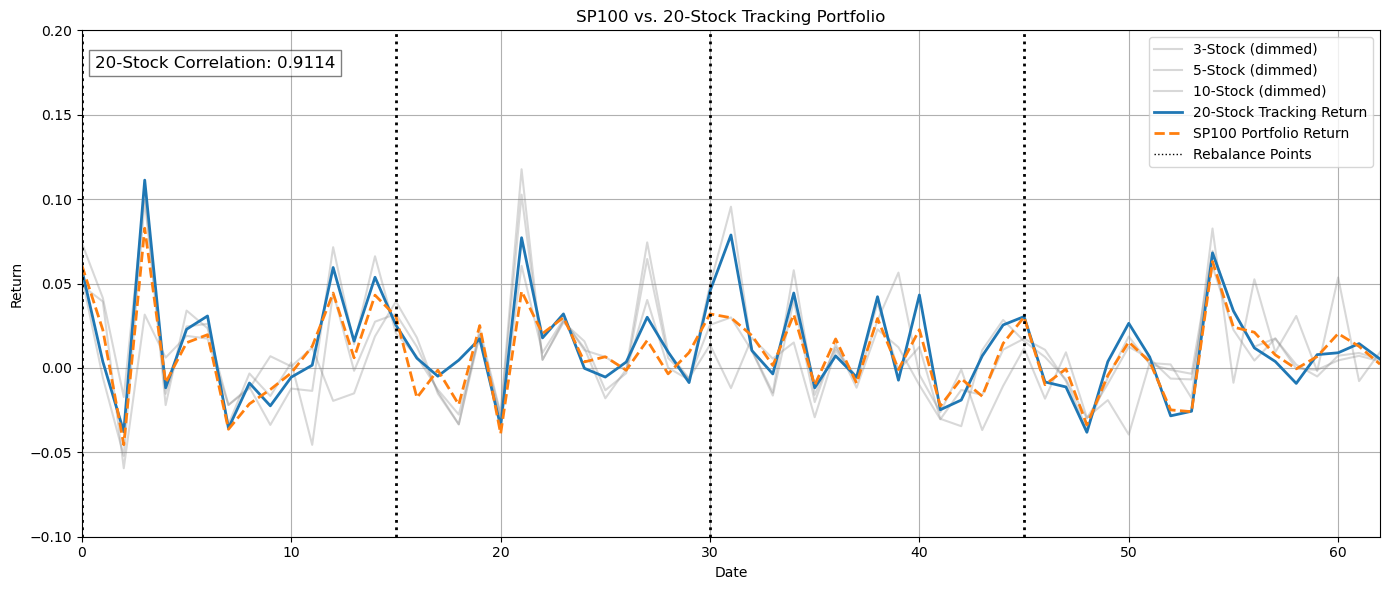

In [27]:

# Plotting one figure per q
for focus_q in qs:
    plt.figure(figsize=(14, 6))

    # Plot all other q returns in gray
    for q in qs:
        if q != focus_q:
            plt.plot(combined[str(q)], color='gray', alpha=0.3, label=f'{q}-Stock (dimmed)')

    # Plot the highlighted q
    plt.plot(combined[str(focus_q)], label=f'{focus_q}-Stock Tracking Return', linewidth=2)

    # Plot SP100
    plt.plot(combined['SP100'], label='SP100 Portfolio Return', linewidth=2, linestyle='--')
    
    for x in period_change_locs:
        plt.axvline(x=x, color='black', linestyle=':', linewidth=2)
        
    rebalance_line = mlines.Line2D([], [], color='black', linestyle=':', linewidth=1, label='Rebalance Points')
    

    # Correlation annotation
    corr = combined['SP100'].corr(combined[str(focus_q)])
    plt.text(
        0.01, 0.95, f'{focus_q}-Stock Correlation: {corr:.4f}',
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.5)
    )

    # Plot formatting
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.ylim(-0.1, 0.2)
    plt.xlim(0, len(combined) - 1)
    plt.title(f'SP100 vs. {focus_q}-Stock Tracking Portfolio')
    plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + [rebalance_line]) 
    plt.grid(True)
    plt.tight_layout()
    plt.show()


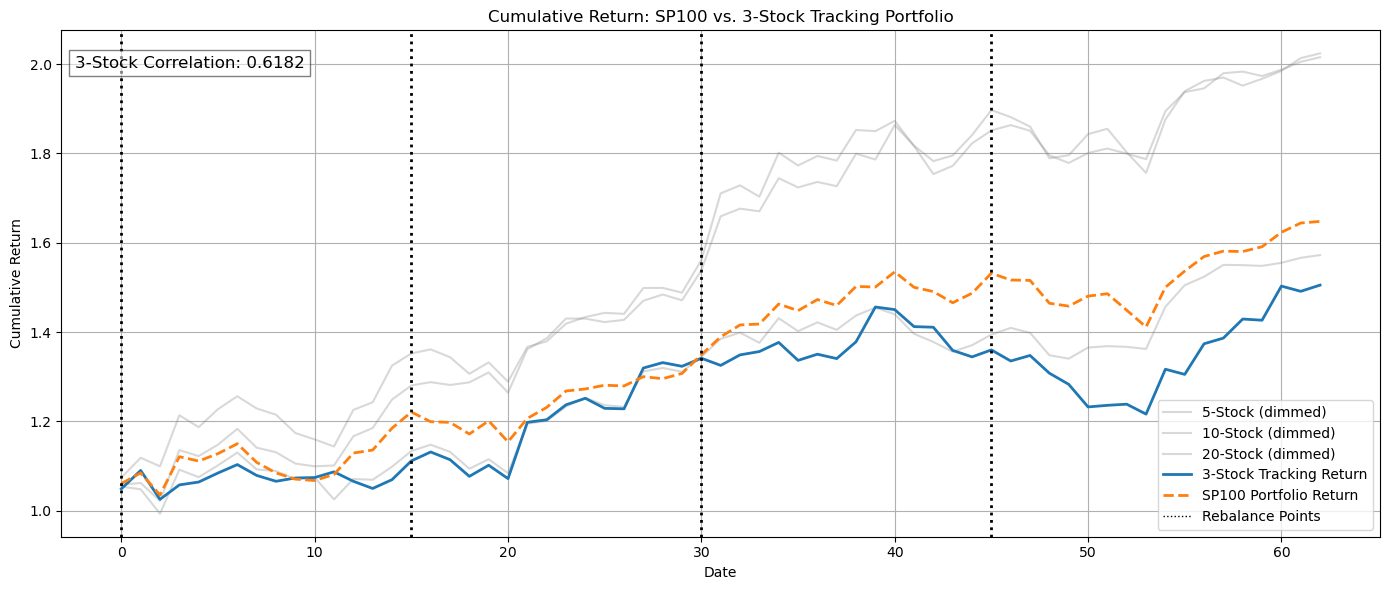

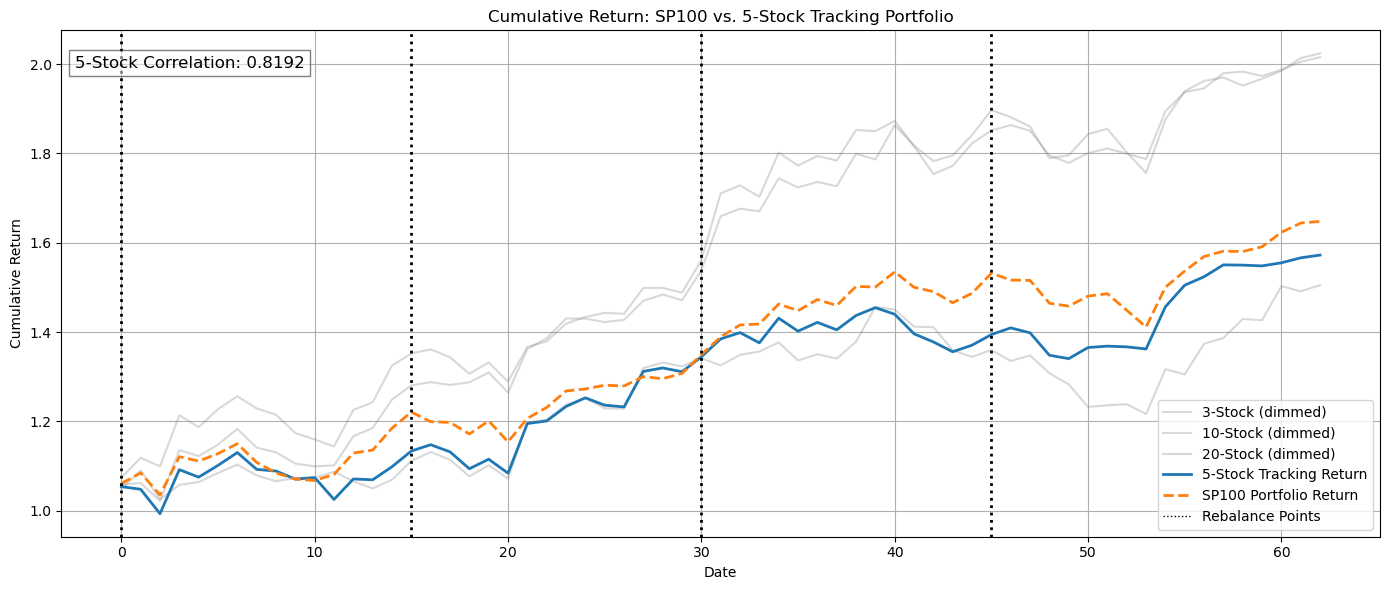

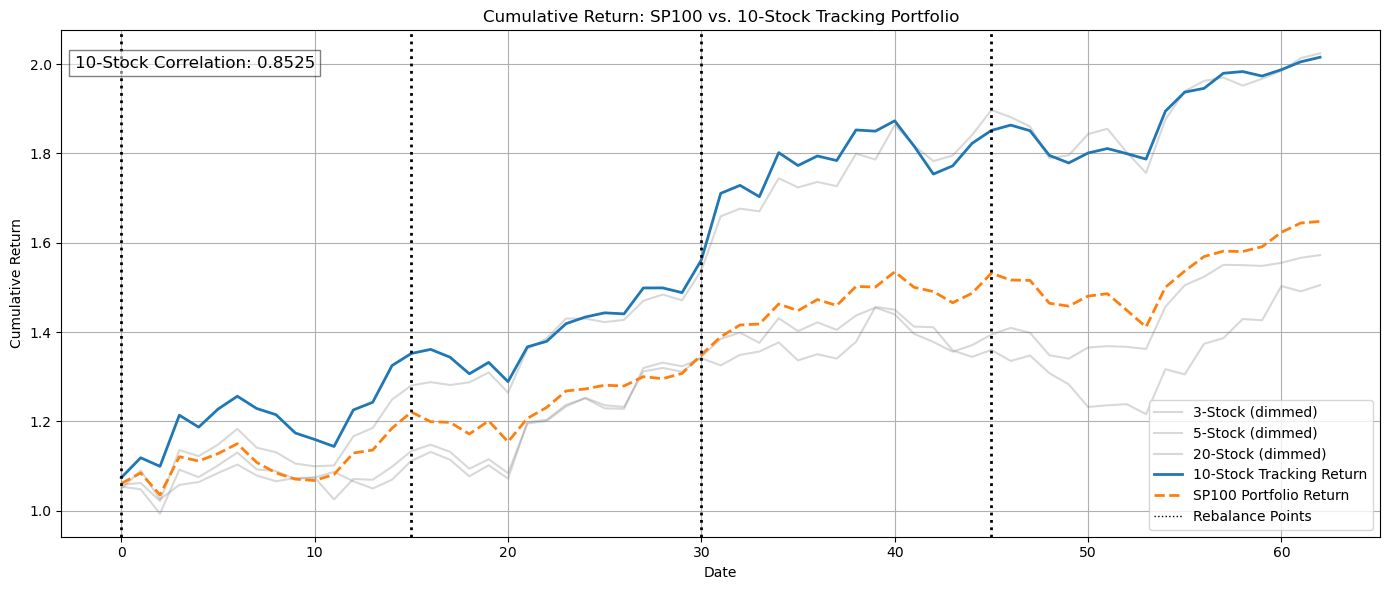

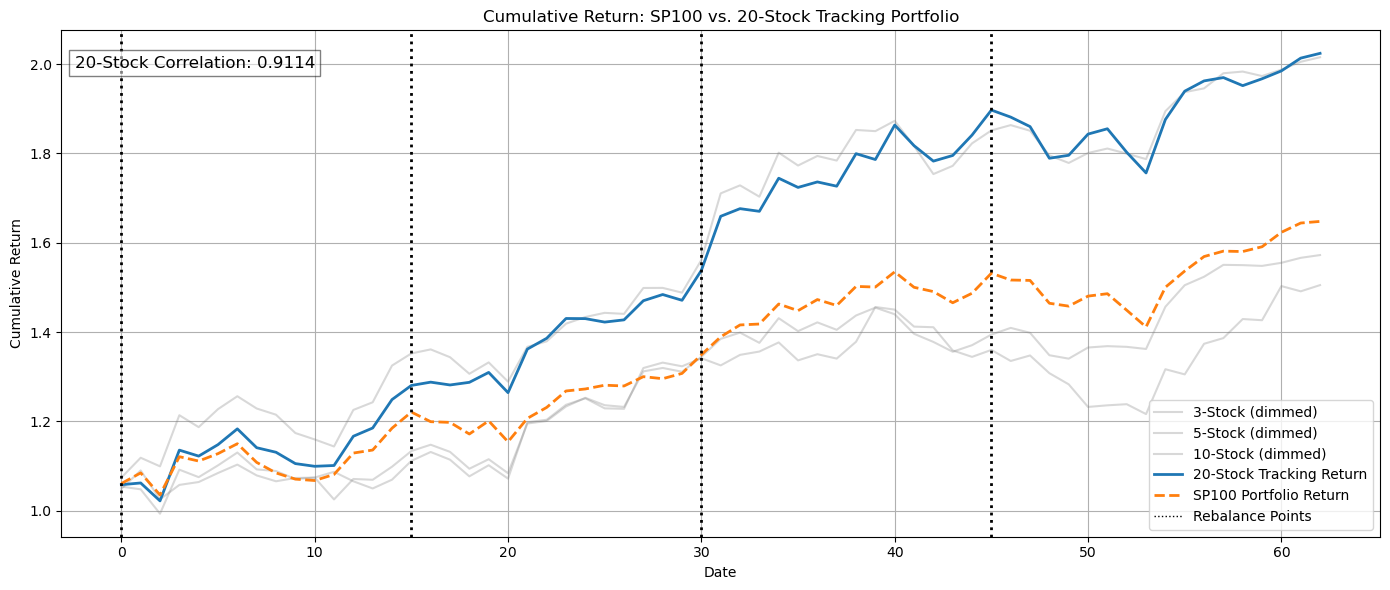

In [28]:
cumulative = (1 + combined).cumprod()

# Plotting one figure per q
for focus_q in qs:
    plt.figure(figsize=(14, 6))

    # Plot all other q returns in gray
    for q in qs:
        if q != focus_q:
            plt.plot(cumulative[str(q)], color='gray', alpha=0.3, label=f'{q}-Stock (dimmed)')

    # Plot the highlighted q
    plt.plot(cumulative[str(focus_q)], label=f'{focus_q}-Stock Tracking Return', linewidth=2)

    # Plot SP100
    plt.plot(cumulative['SP100'], label='SP100 Portfolio Return', linewidth=2, linestyle='--')
    
    for x in period_change_locs:
        plt.axvline(x=x, color='black', linestyle=':', linewidth=2)
        
    rebalance_line = mlines.Line2D([], [], color='black', linestyle=':', linewidth=1, label='Rebalance Points')

    # Correlation annotation (on raw returns, not cumulative)
    corr = combined['SP100'].corr(combined[str(focus_q)])
    plt.text(
        0.01, 0.95, f'{focus_q}-Stock Correlation: {corr:.4f}',
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.5)
    )

    # Plot formatting
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title(f'Cumulative Return: SP100 vs. {focus_q}-Stock Tracking Portfolio')
    plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + [rebalance_line]) 
    plt.grid(True)
    plt.tight_layout()
    plt.show()